In [3]:

# 6. Load BERT model
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# 7. Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy', 'AUC'])



All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:

# 9. Evaluate
print("\n--- Evaluation Metrics ---")
model.evaluate(test_dataset)

# 10. Classification Report
y_probs = model.predict(test_dataset).logits
y_pred = np.argmax(y_probs, axis=1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 11. AUC Score
auc_score = roc_auc_score(y_test, tf.nn.softmax(y_probs)[:, 1])
print(f"AUC Score: {auc_score:.4f}")

# 12. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 13. Plotting training history
def plot_history(history):
    metrics = ['accuracy', 'auc']
    for metric in metrics:
        plt.figure(figsize=(6, 4))
        plt.plot(history.history[metric], label=f'Train {metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'Val {metric}')
        plt.xlabel('Epoch')
        plt.ylabel(metric.title())
        plt.title(f'{metric.title()} over Epochs')
        plt.legend()
        plt.grid(True)
        plt.show()

    # Loss plot
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call to plot the history
plot_history(history)


--- Evaluation Metrics ---


ValueError: in user code:

    File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py", line 2063, in test_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py", line 2046, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py", line 2034, in run_step  **
        outputs = model.test_step(data)
    File "/usr/local/lib/python3.11/dist-packages/transformers/modeling_tf_utils.py", line 1795, in test_step
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/compile_utils.py", line 620, in update_state
        metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/utils/metrics_utils.py", line 77, in decorated
        result = update_state_fn(*args, **kwargs)
    File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/metrics/base_metric.py", line 140, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/metrics/confusion_metrics.py", line 1486, in update_state  **
        return metrics_utils.update_confusion_matrix_variables(
    File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/utils/metrics_utils.py", line 672, in update_confusion_matrix_variables
        y_pred.shape.assert_is_compatible_with(y_true.shape)

    ValueError: Shapes (None, 2) and (None, 1) are incompatible


In [6]:
# 1. Imports
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Load & prepare data
true_df = pd.read_csv('/kaggle/input/news-set1/True.csv')
fake_df = pd.read_csv('/kaggle/input/news-set1/Fake.csv')
true_df['label'], fake_df['label'] = 0, 1
df = pd.concat([true_df[['text','label']], fake_df[['text','label']]], ignore_index=True).dropna()

# 3. Train‑test split
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['label'],
    test_size=0.2, stratify=df['label'], random_state=42
)

# 4. Tokenize
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_enc = tokenizer(list(X_train), padding=True, truncation=True, max_length=512, return_tensors='tf')
test_enc  = tokenizer(list(X_test),  padding=True, truncation=True, max_length=512, return_tensors='tf')

y_train_tf = tf.convert_to_tensor(y_train.values)
y_test_tf  = tf.convert_to_tensor(y_test.values)

train_ds = tf.data.Dataset.from_tensor_slices((dict(train_enc), y_train_tf)) \
             .shuffle(1_000).batch(16).prefetch(tf.data.AUTOTUNE)
test_ds  = tf.data.Dataset.from_tensor_slices((dict(test_enc),  y_test_tf)) \
             .batch(16).prefetch(tf.data.AUTOTUNE)

# 5. Load & compile model
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.compile(
    optimizer=tf.keras.optimizers.Adam(2e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# 6. Train
history = model.fit(train_ds, validation_data=test_ds, epochs=3)

# 7. Evaluate
print("\n=== Final Evaluation on Test Set ===")
model.evaluate(test_ds)

# 8. Predictions & reports
logits = model.predict(test_ds).logits
probs  = tf.nn.softmax(logits, axis=-1).numpy()
y_pred = np.argmax(probs, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 9. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real','Fake'], yticklabels=['Real','Fake'])
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix')
plt.show()

# 10. ROC Curve & AUC
fpr, tpr, _ = roc_curve(y_test, probs[:,1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0,1],[0,1],'--')  # random line
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve'); plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# 11. Plot training history
def plot_history(hist):
    # Accuracy
    plt.figure(figsize=(6,4))
    plt.plot(hist.history['accuracy'], label='Train Acc')
    plt.plot(hist.history['val_accuracy'], label='Val Acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs'); plt.legend(); plt.grid(True)
    plt.show()

    # Loss
    plt.figure(figsize=(6,4))
    plt.plot(hist.history['loss'], label='Train Loss')
    plt.plot(hist.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.title('Loss over Epochs'); plt.legend(); plt.grid(True)
    plt.show()

plot_history(history)


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


ResourceExhaustedError: Graph execution error:

Detected at node tf_bert_for_sequence_classification_2/bert/encoder/layer_._10/attention/self/Softmax defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipykernel_31/3240488151.py", line 45, in <cell line: 0>

  File "/usr/local/lib/python3.11/dist-packages/transformers/modeling_tf_utils.py", line 1209, in fit

  File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py", line 1804, in fit

  File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py", line 1398, in train_function

  File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py", line 1381, in step_function

  File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py", line 1370, in run_step

  File "/usr/local/lib/python3.11/dist-packages/transformers/modeling_tf_utils.py", line 1652, in train_step

  File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py", line 588, in __call__

  File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/base_layer.py", line 1142, in __call__

  File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/transformers/modeling_tf_utils.py", line 1734, in run_call_with_unpacked_inputs

  File "/usr/local/lib/python3.11/dist-packages/transformers/models/bert/modeling_tf_bert.py", line 1746, in call

  File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/base_layer.py", line 1142, in __call__

  File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/transformers/modeling_tf_utils.py", line 1734, in run_call_with_unpacked_inputs

  File "/usr/local/lib/python3.11/dist-packages/transformers/models/bert/modeling_tf_bert.py", line 969, in call

  File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/base_layer.py", line 1142, in __call__

  File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/transformers/models/bert/modeling_tf_bert.py", line 603, in call

  File "/usr/local/lib/python3.11/dist-packages/transformers/models/bert/modeling_tf_bert.py", line 609, in call

  File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/base_layer.py", line 1142, in __call__

  File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/transformers/models/bert/modeling_tf_bert.py", line 502, in call

  File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/base_layer.py", line 1142, in __call__

  File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/transformers/models/bert/modeling_tf_bert.py", line 386, in call

  File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/base_layer.py", line 1142, in __call__

  File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/transformers/models/bert/modeling_tf_bert.py", line 299, in call

  File "/usr/local/lib/python3.11/dist-packages/transformers/tf_utils.py", line 72, in stable_softmax

OOM when allocating tensor with shape[16,12,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node tf_bert_for_sequence_classification_2/bert/encoder/layer_._10/attention/self/Softmax}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_78940]

In [1]:
train_enc = tokenizer(
    list(X_train),
    padding=True,
    truncation=True,
    max_length=128,       # ← was 512
    return_tensors='tf'
)
test_enc = tokenizer(
    list(X_test),
    padding=True,
    truncation=True,
    max_length=128,       # ← was 512
    return_tensors='tf'
)


NameError: name 'tokenizer' is not defined

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((dict(train_enc), y_train_tf)) \
    .shuffle(1_000).batch(8).prefetch(tf.data.AUTOTUNE)   # ← was .batch(16)

test_ds = tf.data.Dataset.from_tensor_slices((dict(test_enc), y_test_tf)) \
    .batch(8).prefetch(tf.data.AUTOTUNE)



In [ ]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
# allow memory growth (optional)
gpus = tf.config.experimental.list_physical_devices('GPU')
for g in gpus:
    tf.config.experimental.set_memory_growth(g, True)

# ——— data prep as before … ———

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_enc = tokenizer(list(X_train), padding=True, truncation=True,
                      max_length=128, return_tensors='tf')
test_enc  = tokenizer(list(X_test),  padding=True, truncation=True,
                      max_length=128, return_tensors='tf')

train_ds = tf.data.Dataset.from_tensor_slices((dict(train_enc), y_train_tf)) \
    .shuffle(1000).batch(8).prefetch(tf.data.AUTOTUNE)
test_ds  = tf.data.Dataset.from_tensor_slices((dict(test_enc),  y_test_tf)) \
    .batch(8).prefetch(tf.data.AUTOTUNE)

model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.compile(
    optimizer=tf.keras.optimizers.Adam(2e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

history = model.fit(train_ds, validation_data=test_ds, epochs=3)


In [1]:
# 1. GPU memory growth (optional, but can help)
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for g in gpus:
    tf.config.experimental.set_memory_growth(g, True)

# 2. Standard imports
import pandas as pd
import numpy as np
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# 3. Load & label data
true_df = pd.read_csv('/kaggle/input/news-set1/True.csv')
fake_df = pd.read_csv('/kaggle/input/news-set1/Fake.csv')
true_df['label'], fake_df['label'] = 0, 1
df = pd.concat([true_df[['text','label']], fake_df[['text','label']]], ignore_index=True).dropna()

# 4. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['label'],
    test_size=0.2, stratify=df['label'], random_state=42
)

# 5. Tokenizer & encode
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_enc = tokenizer(
    list(X_train),
    padding=True,
    truncation=True,
    max_length=128,     # shorter sequences = less memory
    return_tensors='tf'
)
test_enc = tokenizer(
    list(X_test),
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors='tf'
)


print("done")

2025-05-06 09:26:49.969422: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746523610.392081      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746523610.504556      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

I0000 00:00:1746523871.651264      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746523871.652010      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


done


In [4]:

y_train_tf = tf.convert_to_tensor(y_train.values)
y_test_tf  = tf.convert_to_tensor(y_test.values)

# 6. Build tf.data datasets
train_ds = tf.data.Dataset.from_tensor_slices((dict(train_enc), y_train_tf)) \
    .shuffle(1000).batch(8).prefetch(tf.data.AUTOTUNE)   # batch=8
test_ds  = tf.data.Dataset.from_tensor_slices((dict(test_enc),  y_test_tf)) \
    .batch(8).prefetch(tf.data.AUTOTUNE)

# 7. Load & compile model
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.compile(
    optimizer=tf.keras.optimizers.Adam(2e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
# 8. Train
history = model.fit(train_ds, validation_data=test_ds, epochs=3)


NameError: name 'tf' is not defined

In [3]:
# 9. Final evaluation
print("\n=== Test Set Evaluation ===")
model.evaluate(test_ds)

# 10. Predictions & classification report
logits = model.predict(test_ds).logits
probs  = tf.nn.softmax(logits, axis=-1).numpy()
y_pred = np.argmax(probs, axis=1)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# 11. Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real','Fake'], yticklabels=['Real','Fake'])
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix')
plt.show()

# 12. ROC curve & AUC
fpr, tpr, _ = roc_curve(y_test, probs[:,1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0,1],[0,1],'--', linewidth=1)
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve'); plt.legend(loc='lower right'); plt.grid(True)
plt.show()

# 13. Plot training history (accuracy & loss)
def plot_history(h):
    # Accuracy
    plt.figure(figsize=(6,4))
    plt.plot(h.history['accuracy'], label='Train Acc')
    plt.plot(h.history['val_accuracy'], label='Val Acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs'); plt.legend(); plt.grid(True)
    plt.show()

    # Loss
    plt.figure(figsize=(6,4))
    plt.plot(h.history['loss'], label='Train Loss')
    plt.plot(h.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.title('Loss over Epochs'); plt.legend(); plt.grid(True)
    plt.show()

plot_history(history)




=== Test Set Evaluation ===


NameError: name 'model' is not defined

In [1]:
1+1

2

In [ ]:
# 1. (Optional) GPU memory growth
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for g in gpus:
    tf.config.experimental.set_memory_growth(g, True)

# 2. Imports
import pandas as pd
import numpy as np
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# 3. Load & label data
true_df = pd.read_csv('/kaggle/input/news-set1/True.csv')
fake_df = pd.read_csv('/kaggle/input/news-set1/Fake.csv')
true_df['label'], fake_df['label'] = 0, 1
df = pd.concat([true_df[['text','label']], fake_df[['text','label']]], ignore_index=True).dropna()

# 4. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['label'],
    test_size=0.2, stratify=df['label'], random_state=42
)

# 5. Tokenize (shorter sequences to save memory)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_enc = tokenizer(
    list(X_train),
    padding=True, truncation=True,
    max_length=128,
    return_tensors='tf'
)
test_enc = tokenizer(
    list(X_test),
    padding=True, truncation=True,
    max_length=128,
    return_tensors='tf'
)

y_train_tf = tf.convert_to_tensor(y_train.values)
y_test_tf  = tf.convert_to_tensor(y_test.values)

# 6. Build tf.data datasets
train_ds = tf.data.Dataset.from_tensor_slices((dict(train_enc), y_train_tf)) \
    .shuffle(1_000).batch(8).prefetch(tf.data.AUTOTUNE)

test_ds  = tf.data.Dataset.from_tensor_slices((dict(test_enc), y_test_tf)) \
    .batch(8).prefetch(tf.data.AUTOTUNE)

# 7. Load & compile BERT
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.compile(
    optimizer=tf.keras.optimizers.Adam(2e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# 8. Train
history = model.fit(train_ds, validation_data=test_ds, epochs=3)

# 9. Final evaluation
print("\n=== Test Set Evaluation ===")
model.evaluate(test_ds)

# 10. Predictions & classification report
logits = model.predict(test_ds).logits
probs  = tf.nn.softmax(logits, axis=-1).numpy()
y_pred = np.argmax(probs, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 11. Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real','Fake'], yticklabels=['Real','Fake'])
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix')
plt.show()

# 12. ROC Curve & AUC
fpr, tpr, _ = roc_curve(y_test, probs[:,1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}', linewidth=2)
plt.plot([0,1],[0,1],'--', linewidth=1)
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve'); plt.legend(loc='lower right'); plt.grid(True)
plt.show()

# 13. Plot training history (accuracy & loss)
def plot_history(h):
    # Accuracy
    plt.figure(figsize=(6,4))
    plt.plot(h.history['accuracy'], label='Train Acc')
    plt.plot(h.history['val_accuracy'], label='Val Acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs'); plt.legend(); plt.grid(True)
    plt.show()

    # Loss
    plt.figure(figsize=(6,4))
    plt.plot(h.history['loss'], label='Train Loss')
    plt.plot(h.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.title('Loss over Epochs'); plt.legend(); plt.grid(True)
    plt.show()

plot_history(history)


Training TF–IDF + LogisticRegression…

=== Classification Report ===
              precision    recall  f1-score   support

           0     0.9865    0.9907    0.9886      4284
           1     0.9914    0.9876    0.9895      4696

    accuracy                         0.9891      8980
   macro avg     0.9890    0.9892    0.9891      8980
weighted avg     0.9891    0.9891    0.9891      8980



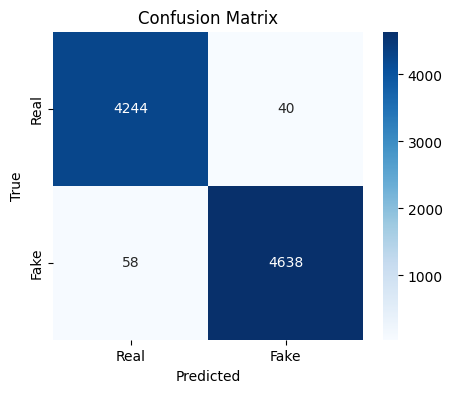

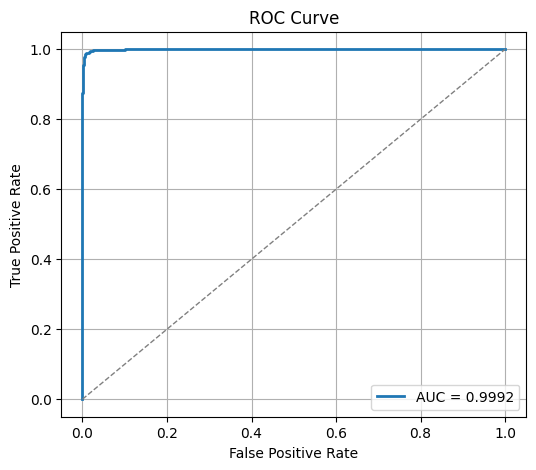

In [2]:
# 1. Imports TF-IDF + Logistic regression
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model      import LogisticRegression
from sklearn.pipeline          import make_pipeline
from sklearn.model_selection   import train_test_split
from sklearn.metrics           import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc
)
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Load & label data
true_df = pd.read_csv('/kaggle/input/news-set1/True.csv')
fake_df = pd.read_csv('/kaggle/input/news-set1/Fake.csv')

true_df['label'] = 0  # real news → 0
fake_df['label'] = 1  # fake news → 1

df = pd.concat([true_df[['text','label']], fake_df[['text','label']]], ignore_index=True)
df.dropna(subset=['text'], inplace=True)

# 3. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['label'],
    test_size=0.20,
    stratify=df['label'],
    random_state=42
)

# 4. Build & train pipeline
pipeline = make_pipeline(
    TfidfVectorizer(
        max_features=10_000,
        ngram_range=(1,2),
        stop_words='english'
    ),
    LogisticRegression(
        C=1.0,
        max_iter=1000,
        solver='liblinear'   # good for small/mid-sized data
    )
)

print("Training TF–IDF + LogisticRegression…")
pipeline.fit(X_train, y_train)

# 5. Predict & evaluate
y_pred  = pipeline.predict(X_test)
y_probs = pipeline.predict_proba(X_test)[:,1]  # probability of class=1 (fake)

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, digits=4))

# 6. Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Real','Fake'],
    yticklabels=['Real','Fake']
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 7. ROC curve & AUC
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc     = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}', linewidth=2)
plt.plot([0,1], [0,1], '--', linewidth=1, color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()



=== Classification Report ===
              precision    recall  f1-score   support

           0     0.9865    0.9907    0.9886      4284
           1     0.9914    0.9876    0.9895      4696

    accuracy                         0.9891      8980
   macro avg     0.9890    0.9892    0.9891      8980
weighted avg     0.9891    0.9891    0.9891      8980



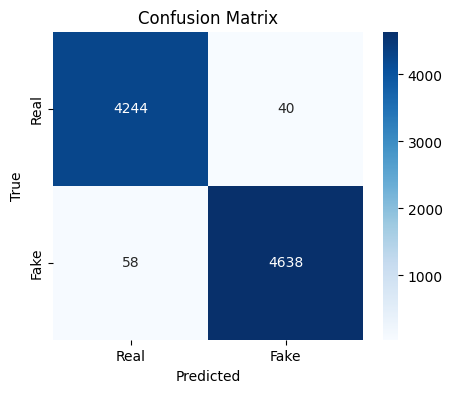

AUC: 0.9992
EER: 0.0110 (at threshold 0.4757)


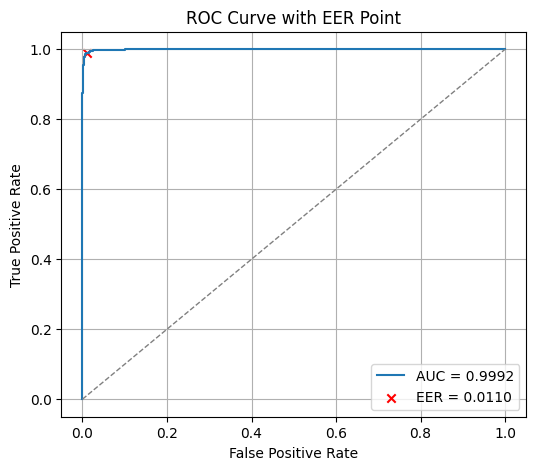

In [3]:
# … (everything up through your y_probs calculation)

# 5. Classification Report
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, digits=4))

# 6. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Real','Fake'],
    yticklabels=['Real','Fake']
)
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix')
plt.show()

# 7. ROC Curve, AUC, and EER
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Compute FNR = 1 - TPR
fnr = 1 - tpr
# Find the threshold where |FPR - FNR| is minimal => EER point
eer_idx = np.nanargmin(np.abs(fnr - fpr))
eer_threshold = thresholds[eer_idx]
eer = fpr[eer_idx]  # or fnr[eer_idx], they’re (nearly) equal

print(f"AUC: {roc_auc:.4f}")
print(f"EER: {eer:.4f} (at threshold {eer_threshold:.4f})")

# Plot ROC
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.scatter(fpr[eer_idx], tpr[eer_idx],
            marker='x', color='red',
            label=f'EER = {eer:.4f}')
plt.plot([0,1], [0,1], '--', linewidth=1, color='gray')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve with EER Point')
plt.legend(loc='lower right'); plt.grid(True)
plt.show()


2025-05-06 09:42:36.743489: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746524557.090411      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746524557.167973      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1746524590.973302      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746524590.974004      31 gpu_device.cc:

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5


I0000 00:00:1746524597.446478     100 cuda_dnn.cc:529] Loaded cuDNN version 90300


1011/1011 ━━━━━━━━━━━━━━━━━━━━ 25s 17ms/step - accuracy: 0.9652 - loss: 0.1052 - val_accuracy: 0.9989 - val_loss: 0.0050
Epoch 2/5
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.9990 - loss: 0.0039 - val_accuracy: 0.9989 - val_loss: 0.0033
Epoch 3/5
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.9997 - loss: 0.0029 - val_accuracy: 0.9989 - val_loss: 0.0054
Epoch 4/5
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.9999 - loss: 4.2739e-04 - val_accuracy: 0.9989 - val_loss: 0.0047
Epoch 5/5
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.9997 - loss: 0.0014 - val_accuracy: 0.9994 - val_loss: 0.0012

=== Test Set Evaluation ===
Test loss: 0.0114,  Test accuracy: 0.9987
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

Classification Report:
              precision    recall  f1-score   support

           0     0.9986    0.9986    0.9986      4284
           1     0.9987    0.9987    0.9987      4696

    accuracy                         0.9987      89

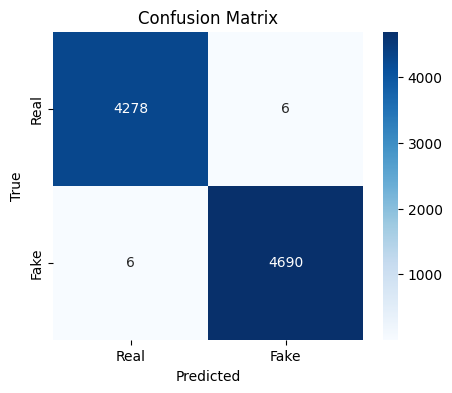

AUC: 0.9999
EER: 0.0014 (threshold 0.7508)


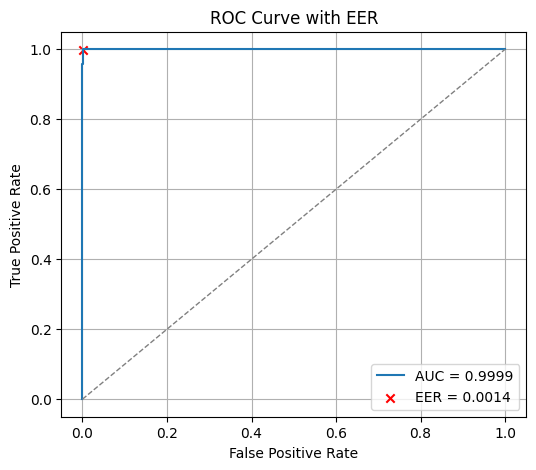

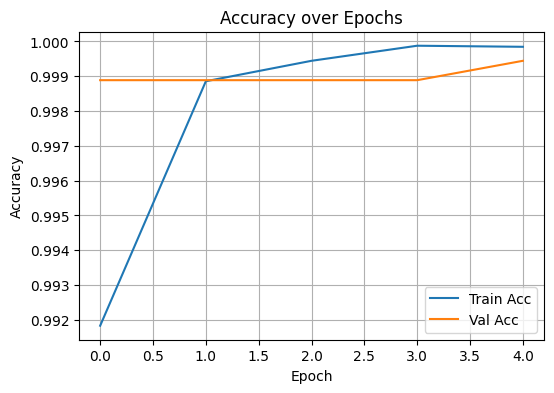

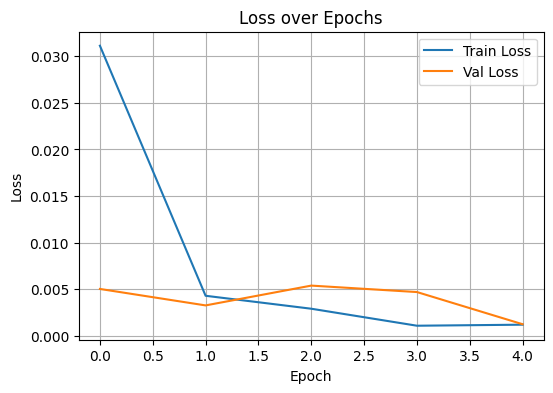

In [4]:
# 1. Imports simple bi-directional lstm
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc
)
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Load & label data
true_df = pd.read_csv('/kaggle/input/news-set1/True.csv')
fake_df = pd.read_csv('/kaggle/input/news-set1/Fake.csv')
true_df['label'], fake_df['label'] = 0, 1
df = pd.concat([true_df[['text','label']], fake_df[['text','label']]], ignore_index=True).dropna()

# 3. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['label'],
    test_size=0.2, stratify=df['label'], random_state=42
)

# 4. Tokenize & pad
max_words   = 20000
max_len     = 200
tokenizer   = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

seq_train = tokenizer.texts_to_sequences(X_train)
seq_test  = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(seq_train, maxlen=max_len, padding='post', truncating='post')
X_test_pad  = pad_sequences(seq_test,  maxlen=max_len, padding='post', truncating='post')

# 5. Build the model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

# 6. Train (with a validation split)
history = model.fit(
    X_train_pad, y_train,
    validation_split=0.1,
    epochs=5,
    batch_size=32
)

# 7. Evaluate on test set
print("\n=== Test Set Evaluation ===")
loss, acc = model.evaluate(X_test_pad, y_test, verbose=0)
print(f"Test loss: {loss:.4f},  Test accuracy: {acc:.4f}")

# 8. Predictions & classification report
y_probs = model.predict(X_test_pad).ravel()
y_pred  = (y_probs >= 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

# 9. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real','Fake'], yticklabels=['Real','Fake'])
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix')
plt.show()

# 10. ROC Curve, AUC & EER
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
fnr     = 1 - tpr
eer_idx = np.nanargmin(np.abs(fnr - fpr))
eer     = fpr[eer_idx]

print(f"AUC: {roc_auc:.4f}")
print(f"EER: {eer:.4f} (threshold {thresholds[eer_idx]:.4f})")

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.scatter(fpr[eer_idx], tpr[eer_idx], color='red', marker='x',
            label=f'EER = {eer:.4f}')
plt.plot([0,1],[0,1],'--', color='gray', linewidth=1)
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve with EER'); plt.legend(loc='lower right'); plt.grid(True)
plt.show()

# 11. Plot training history
def plot_history(h):
    # Accuracy
    plt.figure(figsize=(6,4))
    plt.plot(h.history['accuracy'], label='Train Acc')
    plt.plot(h.history['val_accuracy'], label='Val Acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs'); plt.legend(); plt.grid(True)
    plt.show()

    # Loss
    plt.figure(figsize=(6,4))
    plt.plot(h.history['loss'], label='Train Loss')
    plt.plot(h.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.title('Loss over Epochs'); plt.legend(); plt.grid(True)
    plt.show()

plot_history(history)



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 200, 100)            │       2,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 200, 128)            │          63,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention (Attention)                │ (None, 128)                 │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,064,001 (7.87 MB)

 Trainable params: 64,001 (250.00 KB)

 Non-trainable params: 2,000,000 (7.63 MB)

Epoch 1/5
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.9198 - loss: 0.1752 - val_accuracy: 0.9980 - val_loss: 0.0095
Epoch 2/5
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - accuracy: 0.9982 - loss: 0.0078 - val_accuracy: 0.9989 - val_loss: 0.0039
Epoch 3/5
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - accuracy: 0.9990 - loss: 0.0037 - val_accuracy: 0.9982 - val_loss: 0.0069
Epoch 4/5
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - accuracy: 0.9996 - loss: 0.0018 - val_accuracy: 0.9989 - val_loss: 0.0040
Epoch 5/5
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - accuracy: 0.9996 - loss: 0.0017 - val_accuracy: 0.9992 - val_loss: 0.0031

=== Test Set Evaluation ===
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9996 - loss: 0.0019
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4284
           1       1.00      1.00      1.00      4696

    accuracy

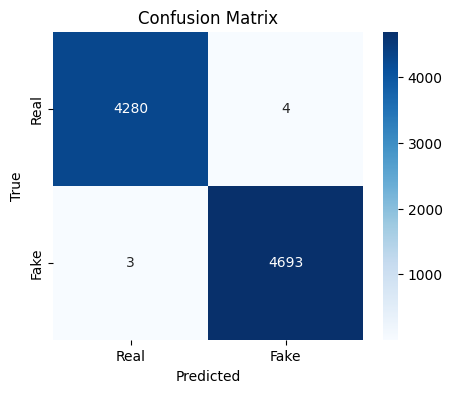

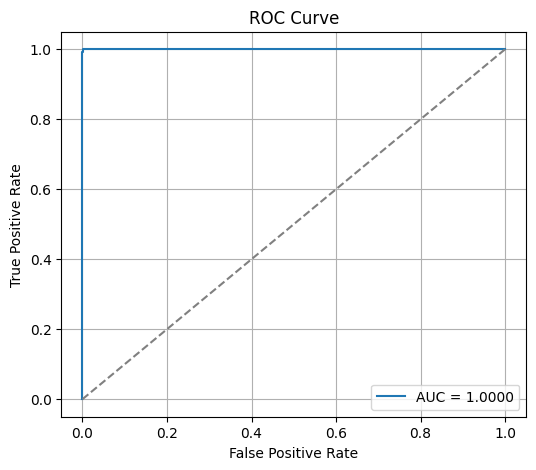

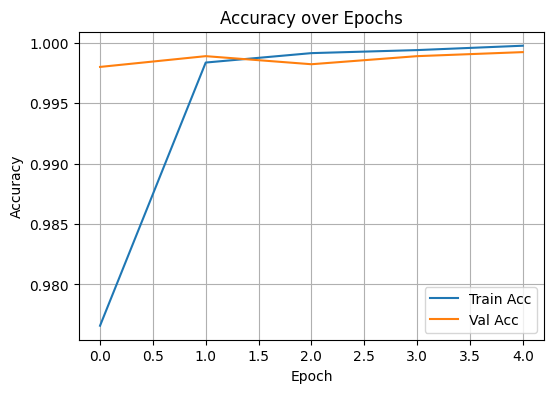

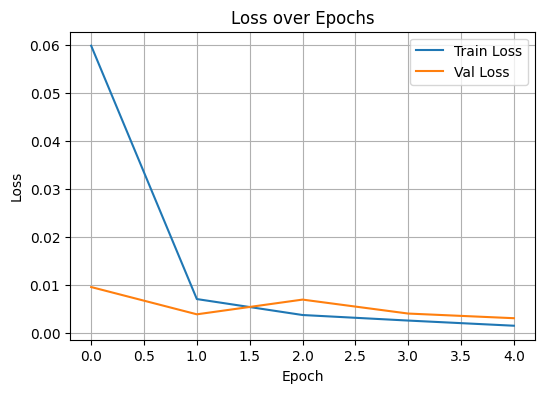

In [10]:


# 1. Imports  bidirectional gru with attention + glove model
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import (Input, Embedding, Bidirectional, GRU,
                                     Dense, Dropout, Layer)
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_curve, auc)
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 2. Load & label data
true_df = pd.read_csv('/kaggle/input/news-set1/True.csv')
fake_df = pd.read_csv('/kaggle/input/news-set1/Fake.csv')
true_df['label'], fake_df['label'] = 0, 1
df = pd.concat([true_df[['text','label']], fake_df[['text','label']]]).dropna()

# 3. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['label'],
    test_size=0.2, stratify=df['label'], random_state=42
)

# 4. Tokenize & pad
MAX_VOCAB = 20000
MAX_LEN   = 200

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

train_seq = tokenizer.texts_to_sequences(X_train)
test_seq  = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad  = pad_sequences(test_seq,  maxlen=MAX_LEN, padding='post', truncating='post')

# 5. Load GloVe embeddings
EMBED_DIM = 100
glove_path = '/kaggle/input/glove-data' # adjust path
emb_index = {}
glove_path = '/kaggle/input/glove-data/glove.6B.100d.txt'
glove_file = os.path.join(glove_path, 'glove.6B.100d.txt')




with open(glove_path, encoding='utf-8') as f:
    for line in f:
        word, *vec = line.strip().split()
        emb_index[word] = np.array(vec, dtype=np.float32)

word_index = tokenizer.word_index
num_words  = min(MAX_VOCAB, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBED_DIM))
for word, i in word_index.items():
    if i >= num_words: continue
    vec = emb_index.get(word)
    if vec is not None:
        embedding_matrix[i] = vec

# 6. Attention layer
class Attention(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight',
                                 shape=(input_shape[-1],),
                                 initializer='random_normal', trainable=True)
    def call(self, inputs):
        # inputs: (batch, timesteps, features)
        e = tf.tensordot(inputs, self.W, axes=1)       # (batch, timesteps)
        alpha = tf.nn.softmax(e, axis=1)                # (batch, timesteps)
        attended = tf.reduce_sum(inputs * tf.expand_dims(alpha, -1), axis=1)
        return attended

# 7. Build model
inp = Input(shape=(MAX_LEN,), dtype='int32')
x   = Embedding(num_words, EMBED_DIM,
                weights=[embedding_matrix],
                input_length=MAX_LEN,
                trainable=False)(inp)
x   = Bidirectional(GRU(64, return_sequences=True))(x)
x   = Attention()(x)
x   = Dropout(0.5)(x)
out = Dense(1, activation='sigmoid')(x)

model = Model(inp, out)
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.summary()

# 8. Train
history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_test_pad, y_test),
    epochs=5,
    batch_size=32
)

# 9. Evaluate
print("\n=== Test Set Evaluation ===")
model.evaluate(X_test_pad, y_test, batch_size=32)

# 10. Predict & report
y_probs = model.predict(X_test_pad, batch_size=32).ravel()
y_pred  = (y_probs >= 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 11. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real','Fake'], yticklabels=['Real','Fake'])
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix')
plt.show()

# 12. ROC & AUC
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc     = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve'); plt.legend(loc='lower right'); plt.grid(True)
plt.show()

# 13. Plot history
def plot_history(h):
    # Accuracy
    plt.figure(figsize=(6,4))
    plt.plot(h.history['accuracy'], label='Train Acc')
    plt.plot(h.history['val_accuracy'], label='Val Acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs'); plt.legend(); plt.grid(True)
    plt.show()
    # Loss
    plt.figure(figsize=(6,4))
    plt.plot(h.history['loss'], label='Train Loss')
    plt.plot(h.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.title('Loss over Epochs'); plt.legend(); plt.grid(True)
    plt.show()

plot_history(history)

